In [1]:
import os
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline

lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader, None)
    for line in reader:
        lines.append(line)

train_data, validation_data = train_test_split(lines, test_size = 0.2)
def augmentation_flip(image, angle):
    flipped_image = np.fliplr(image)
    flipped_angle = -angle
    return flipped_image, flipped_angle

def preprocessing_images(image):
    #corping the top and bottom image
    new_image = image[50:140,:,:]
    #converting to YUV color space as (nivida's paper's structure)
    new_image = cv2.resize(new_image,(200, 66), interpolation = cv2.INTER_AREA)
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2YUV) 
    #normalization

    return new_image
def image_generator(samples, flipped_aug = True, batch_size = 32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles=[]
            for batch_sample in batch_samples:
                name = 'data/IMG/' + batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                
                # Converting image to YUV color space, resize to 66 * 200 and normalize
                center_image = preprocessing_images(center_image)
                
                images.append(center_image)
                angles.append(center_angle)
                if flipped_aug == True:
                    flipped_image, flipped_angle = augmentation_flip(center_image, center_angle)
                    images.append(flipped_image)
                    angles.append(flipped_angle)
            X_image = np.array(images)
            y_angle = np.array(angles)
            yield shuffle(X_image, y_angle)

train_generator = image_generator(train_data, batch_size = 32)
validation_generator = image_generator( validation_data, batch_size = 32)



(array([  739.,   666.,   969.,  1537.,  1684.,   330.,  1192.,   662.,
          556.,   842.]),
 array([-0.9663736 , -0.76973624, -0.57309888, -0.37646152, -0.17982416,
         0.0168132 ,  0.21345056,  0.41008792,  0.60672528,  0.80336264,  1.        ]),
 <a list of 10 Patch objects>)

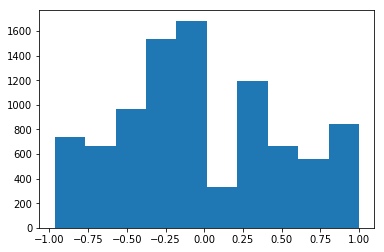

In [16]:
steering_angles = []
for line in lines:
    control = np.random.choice(10,1)
    if control[0] < 1 or np.abs(float(line[3])) > 0.2:
        steering_angles.append(float(line[3]))
steering_angles = np.array(steering_angles)

plt.hist(steering_angles)

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2

model = Sequential()
model.add(Lambda(lambda x: x / 255. - 0.5, input_shape = (66, 200, 3)))
#The network structre is mimicing from Nvidia' paper
#First with 3 5x5 convolutional layers
    #First 5x5 convlutional layer 24 filters
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), W_regularizer=l2(0.005)))

model.add(Activation('relu'))
    #Second 5x5 convlutional layer 36 filters
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), W_regularizer=l2(0.005)))
model.add(Activation('relu'))
    #Third 5x5 convlutional layer 48 filters
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), W_regularizer=l2(0.005)))
model.add(Activation('relu'))

#Then with 2 1-stride 3x3 convlolutional layers
    #First3x3 convolutional layer
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), W_regularizer=l2(0.001)))
model.add(Activation('relu'))
    #First3x3 convolutional layer
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), W_regularizer=l2(0.001)))
model.add(Activation('relu'))

#At last with 3 fully connected layers
    #Flatten the previous results
model.add(Flatten())
    #First fully connected layer
model.add(Dense(100, W_regularizer=l2(0.001)))
model.add(Activation('relu'))
    #Second fully connected layer
model.add(Dense(50, W_regularizer=l2(0.001)))
model.add(Activation('relu'))
    #Third fully connected layer
model.add(Dense(10, W_regularizer=l2(0.001)))
model.add(Activation('relu'))

#Output layer
model.add(Dense(1, W_regularizer=l2(0.001)))
keras.optimizers.Adam(lr=0.01)
model.compile(loss = 'mse', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch=\
                    len(train_data) * 2, validation_data=validation_generator,\
            nb_val_samples=len(validation_data), nb_epoch=7)

model.save('model.h5')


Using TensorFlow backend.


Epoch 1/7
42288/42288 [==============================] - 24s - loss: 0.1424 - val_loss: 0.0871
Epoch 2/7
42288/42288 [==============================] - 23s - loss: 0.0866 - val_loss: 0.0829
Epoch 3/7
42288/42288 [==============================] - 23s - loss: 0.0825 - val_loss: 0.0853
Epoch 4/7
42288/42288 [==============================] - 23s - loss: 0.0812 - val_loss: 0.0800
Epoch 5/7
42288/42288 [==============================] - 23s - loss: 0.0801 - val_loss: 0.0799
Epoch 6/7
42288/42288 [==============================] - 23s - loss: 0.0798 - val_loss: 0.0798
Epoch 7/7
42288/42288 [==============================] - 23s - loss: 0.0794 - val_loss: 0.0742


In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2

model = Sequential()
model.add(Lambda(lambda x: x / 255. - 0.5, input_shape = (66, 200, 3)))
#The network structre is mimicing from Nvidia' paper
#First with 3 5x5 convolutional layers
    #First 5x5 convlutional layer 24 filters
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), W_regularizer=l2(0.005)))

model.add(Activation('relu'))
    #Second 5x5 convlutional layer 36 filters
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), W_regularizer=l2(0.005)))
model.add(Activation('relu'))
    #Third 5x5 convlutional layer 48 filters
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), W_regularizer=l2(0.005)))
model.add(Activation('relu'))

#Then with 2 1-stride 3x3 convlolutional layers
    #First3x3 convolutional layer
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), W_regularizer=l2(0.001)))
model.add(Activation('relu'))
    #First3x3 convolutional layer
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), W_regularizer=l2(0.001)))
model.add(Activation('relu'))

#At last with 3 fully connected layers
    #Flatten the previous results
model.add(Flatten())
    #First fully connected layer
model.add(Dense(100, W_regularizer=l2(0.001)))
model.add(Activation('relu'))
    #Second fully connected layer
model.add(Dense(50, W_regularizer=l2(0.001)))
model.add(Activation('relu'))
    #Third fully connected layer
model.add(Dense(10, W_regularizer=l2(0.001)))
model.add(Activation('relu'))

#Output layer
model.add(Dense(1, W_regularizer=l2(0.001)))
keras.optimizers.Adam(lr=0.0001)
model.compile(loss = 'mse', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch=\
                    len(train_data) * 2, validation_data=validation_generator,\
            nb_val_samples=len(validation_data), nb_epoch=7)

model.save('model1.h5')

Epoch 1/7
50596/50596 [==============================] - 29s - loss: 0.1387 - val_loss: 0.0972
Epoch 2/7
50596/50596 [==============================] - 28s - loss: 0.0934 - val_loss: 0.0918
Epoch 3/7
50596/50596 [==============================] - 28s - loss: 0.0898 - val_loss: 0.0933
Epoch 4/7
50596/50596 [==============================] - 28s - loss: 0.0884 - val_loss: 0.0885
Epoch 5/7
50596/50596 [==============================] - 28s - loss: 0.0877 - val_loss: 0.0899
Epoch 6/7
50596/50596 [==============================] - 28s - loss: 0.0870 - val_loss: 0.0883
Epoch 7/7
50596/50596 [==============================] - 28s - loss: 0.0869 - val_loss: 0.0888


In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2

model = Sequential()
model.add(Lambda(lambda x: x / 255. - 0.5, input_shape = (66, 200, 3)))
#The network structre is mimicing from Nvidia' paper
#First with 3 5x5 convolutional layers
    #First 5x5 convlutional layer 24 filters
model.add(Convolution2D(24, 5, 5, subsample=(2, 2)))

model.add(Activation('relu'))
    #Second 5x5 convlutional layer 36 filters
model.add(Convolution2D(36, 5, 5, subsample=(2, 2)))
model.add(Activation('relu'))
    #Third 5x5 convlutional layer 48 filters
model.add(Convolution2D(48, 5, 5, subsample=(2, 2)))
model.add(Activation('relu'))

#Then with 2 1-stride 3x3 convlolutional layers
    #First3x3 convolutional layer
model.add(Convolution2D(64, 3, 3, subsample=(1, 1)))
model.add(Activation('relu'))
    #First3x3 convolutional layer
model.add(Convolution2D(64, 3, 3, subsample=(1, 1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
#At last with 3 fully connected layers
    #Flatten the previous results
model.add(Flatten())
    #First fully connected layer
model.add(Dense(100))
model.add(Activation('relu'))
    #Second fully connected layer
model.add(Dense(50))
model.add(Activation('relu'))
    #Third fully connected layer
model.add(Dense(10))
model.add(Activation('relu'))

#Output layer
model.add(Dense(1))
keras.optimizers.Adam(lr=0.00001)
model.compile(loss = 'mse', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch=\
                    len(train_data) * 2, validation_data=validation_generator,\
            nb_val_samples=len(validation_data), nb_epoch=5)

model.save('model2.h5') 
    
    

Epoch 1/5
50596/50596 [==============================] - 29s - loss: 0.0798 - val_loss: 0.0690
Epoch 2/5
50596/50596 [==============================] - 28s - loss: 0.0687 - val_loss: 0.0699
Epoch 3/5
50596/50596 [==============================] - 28s - loss: 0.0646 - val_loss: 0.0633
Epoch 4/5
50596/50596 [==============================] - 28s - loss: 0.0614 - val_loss: 0.0658
Epoch 5/5
50596/50596 [==============================] - 28s - loss: 0.0587 - val_loss: 0.0602


In [10]:
import keras
print(keras.__version__)
, W_regularizer=l2(0.005)

1.2.1


In [ ]:

import base64
from datetime import datetime
import os
import shutil

import numpy as np
import socketio
import eventlet
import eventlet.wsgi
from PIL import Image
from flask import Flask
from io import BytesIO

from keras.models import load_model
import h5py
from keras import __version__ as keras_version

sio = socketio.Server()
app = Flask(__name__)
model = None
prev_image_array = None